### ***Theory of artificial neural network***
An Artificial Neural Network (ANN) is a supervised ML model inspired by the way biological neural networks in the human brain process information. It consists of layers of interconnected **neurons** that work together to recognize patterns, make decisions, or perform complex tasks.

#### ***Structure***
An ANN consists of layers of neurons connected by weighted edges. It can be represented as a function $f: X \rightarrow Y$, where $X$ represents the input (samples' features' values) and $Y$ the output.

##### ***Layers***
1. **input layer**: a set of neurons (which cardinality is the number of features in a given dataset) which receives raw data and passes it to the next layer

2. *(many)* **hidden layers**: intermediate layers where computation occur. It's where the non-liner transformations are applied via **activation function**

3. **output layer**: produces the final computed/predicted result

Given an ANN with $L$ layers, $\mathbf{x}^{(0)}$ the input vector, then for each layer $l$:
$$\mathbf{x}^{(l)} = \sigma(\mathbf{z}^{(l)})$$

$$\mathbf{z}^{(l)} = \mathbf{W}^{(l)}\mathbf{x}^{(l-1)} + \mathbf{b}^{(l)}$$
where:
*   $\mathbf{W}^{(l)}$ is the weight matrix of layer $l$
*   $\mathbf{b}^{(l)}$ is the bias vector
*   $\mathbf{z}^{(l)}$ is the weighted sum of values of layer $l-1$
*   $\mathbf{\sigma}$ is the activation function
*   $\mathbf{x}^{(l)}$  is the output after activation

#### ***Activation functions***
The **activation function** is used for introducing non-linearity into the model, allowing the network to learn and represent complex patterns in the data. Without this non-linearity feature, a neural network would behave like a linear regression model, no matter how many layers it has.

##### ***Common functions***
1.  **Sigmoid function** ( maps values into the range (0, 1) ):

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

2.  **Hyperbolic Tangent (Tanh) Function**:

$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

3.	**ReLU (Rectified Linear Unit)** (common in deep networks):

$$\text{ReLU}(x) = \max(0, x)$$

4.	**Softmax Function** (used in classification tasks):

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$

#### ***Learning and Optimization***
ANNs learn by adjusting weights and bias using an optimization technique called **gradient descent** (and all its optimized versions). The objective is to minimize a **loss function** $J(\mathbf{y}, \mathbf{\hat{y}})$, where $\mathbf{y}$ is the expected output and $\mathbf{\hat{y}}$ is the predicted output.

##### ***Main Loss Functions***
*   **Mean Squared Error (MSE)** (good for regression tasks):
$$
J_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$
*   **Cross-Entropy Loss** (good for classification tasks):
$$
J_{x-entropy} = -\frac{1}{N} \sum_i^N y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)
$$

#### ***Backpropagation Algorithm***
Backpropagation is a form of **reverse-mode automatic differentiation** used to compute the **gradient** of the loss function with respect to each **weight** and **bias**:

1.	***Forward pass***: compute the network’s output.
2.	***Loss computation***: evaluate how far the prediction is from the target.
3.	***Backward pass (gradient computation)***: compute gradients of the loss function w.r.t. each parameter using the chain rule:
$$
\frac{\partial J}{\partial W^{(l)}} = \frac{\partial J}{\partial x^{(l)}} \cdot \frac{\partial x^{(l)}}{\partial z^{(l)}} \cdot \frac{\partial z^{(l)}}{\partial W^{(l)}}
$$
$$
\frac{\partial J}{\partial W^{(l)}} = \frac{\partial J}{\partial x^{(l)}} \cdot \frac{\partial x^{(l)}}{\partial z^{(l)}} \cdot \frac{\partial z^{(l)}}{\partial W^{(l)}}
$$
4.	**Parameter update**: adjust weights and bias using **gradient descent** (or variants like SGD, RMSProp, ...): $$W^{(k+1)} \leftarrow W^{(k)} - \mathbf{\eta} \frac{\partial J}{\partial W^{(k)}}$$ where $\eta$ is the **learning rate**.


#### ***Import libraries***

In [136]:
import sys
sys.path.append('../')

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import utils.model_evaluation as me
import pandas as pd

from utils.models.base_model import BaseModel
from utils.preprocessing import *
from utils.data_processer import *

### ***Model definition***

In [137]:
class ANN(BaseModel):
    def __init__(self, layers_size=None, act_func=jnp.tanh, out_act_fun=jax.nn.sigmoid):
        """
        A class representing an artificial neural network configuration for specifying the structure
        and activation functions of each layer in the network.

        This class encapsulates the size of the layers, the activation function for intermediate layers,
        and the output activation function.

        :param layers_size: List specifying the size of each layer of the neural network.
            This includes both input and output layer sizes.
        :type layers_size: Optional[List[int]]

        :param act_func: Activation function to be applied to the intermediate layers
            of the neural network. Defaults to hyperbolic tangent (jnp.tanh).
        :type act_func: Callable

        :param out_act_fun: Activation function to be applied to the output layer of the
            neural network. Defaults to sigmoid (jax.nn.sigmoid).
        :type out_act_fun: Callable
        """

        self.layers_size = layers_size
        self.act_func = act_func
        self.out_act_fun = out_act_fun

    def initialize_parameters(self, layers_size):
        """
            Returns the parameters of the artificial neural network given the number of
            neurons in its layers. Specifically, it sets the matrix of weights and the
            bias vector for each layer, initialized randomly.

            :param layers_size: Ordered sizes of the layers of the artificial neural network.
            :type layers_size: list
            :return: Parameters of the artificial neural network, specifically weights and biases.
            :rtype: list
        """

        layers_size = jnp.array(layers_size)
        np.random.seed(0)  # For reproducibility
        self.layers_size = layers_size

        params = list()
        for i in range(len(self.layers_size) - 1):
            W = np.random.randn(self.layers_size[i + 1], self.layers_size[i])
            b = np.zeros((self.layers_size[i + 1], 1))

            params.append(W)
            params.append(b)

        return params

    def MSW(self, params):
        """
        Computes the mean squared weights (MSW) of an artificial neural network's weights.

        This function calculates the average of the squared values of the weights present
        in the given parameters of an artificial neural network. Typically, the weights
        and biases are passed as a list, where this function processes only the weights.

        :param params: Parameters of the artificial neural network, usually alternating
            weights and biases
        :type params: list
        :return: Mean of squared weights of the artificial neural network
        :rtype: float
        """

        # Extract weights
        weights = params[::2]

        # Calculate MSW
        partial_sum = 0.0
        n_weights = 0
        for W in weights:
            partial_sum = partial_sum + jnp.sum(W * W)
            n_weights = n_weights + W.size

        return partial_sum / n_weights

    # Loss functions
    def cross_entropy(self):
        """
        Defines the cross-entropy loss function for classification problems with
        logistic output. This function calculates the negative log-likelihood
        of the predictions made by the model when compared with the true labels.
        It is commonly used as a loss function for binary classification tasks.

        :returns: A callable function that computes the cross-entropy loss
            for given input features, true labels, and model parameters. The
            callable expects three arguments: x (input features), y (true labels),
            and params (model parameters).
        :rtype: Callable
        """
        def callable(x, y, params):
            y_pred = self.predict(x, params)
            return -jnp.mean(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))

        return callable

    def MSE(self):
        """
        Defines a callable function that computes the Mean Squared Error (MSE) between
        the predicted and actual values using provided parameters.

        :returns: A callable function that computes the Mean Squared Error
            for given input features, true labels, and model parameters. The
            callable expects three arguments: x (input features), y (true labels),
            and params (model parameters).
        :rtype: Callable
        """
        def callable(x, y, params):
            y_pred = self.predict(x, params)
            return jnp.mean((y_pred - y) ** 2)

        return callable

    def regularized_loss(self, loss_function, penalization):
        """
        Computes a regularized loss function by combining the given loss function with
        a penalization term. The penalization term is scaled based on the dataset size
        and involves the Mean Squared Weight (MSW) for the provided parameters.

        This method returns a callable function that takes `x`, `y`, and `params` as inputs
        and computes the regularized loss by applying the given loss function and adding
        the scaled penalization term.

        :param loss_function: A callable function representing the loss function to be
            applied to the dataset. It should accept `x`, `y`, and `params` as inputs.
        :param penalization: A scalar value representing the penalization term to be
            applied during regularization. This value is combined with the MSW.
        :return: Returns a callable function which computes the regularized loss as a
            combination of the loss function and the penalization term.
        """
        def callable(x, y, params):
            return loss_function(x, y, params) + penalization / (2 * x.shape[0]) * self.MSW(params)

        return callable

    # Optimisation algorithms
    def SGD(
            self,
            loss_function,
            epochs=1000,
            batch_size=128,
            learning_rate_min=1e-3,
            learning_rate_max=1e-1,
            learning_rate_decay=1000,
    ):
        """
        Creates a Stochastic Gradient Descent (SGD) optimizer as a callable function.

        This optimizer performs parameter updates based on gradient descent using
        a randomly selected batch of data at each iteration. The learning rate
        decays linearly over the specified number of epochs. The optimization
        process history, including the loss at each epoch, is also recorded and
        returned.

        :param loss_function: The loss function used to guide the optimization
            process. Should accept inputs, labels, and model parameters, and
            return a scalar loss value.
        :param epochs: The total number of iterations for training the model.
        :param batch_size: The number of samples to randomly select for computing
            gradients at each iteration.
        :param learning_rate_min: The minimum boundary for the learning rate.
        :param learning_rate_max: The initial maximum learning rate.
        :param learning_rate_decay: The rate at which the learning rate decreases
            linearly over the epochs. The learning rate reaches `learning_rate_min`
            when `epochs` are completed.
        :return: A callable optimizer function that applies SGD on the provided
            data and model parameters and returns the updated parameters and a
            history of loss values over all epochs.
        """

        def callable(x_train, y_train, params):
            # Number of samples
            num_samples = x_train.shape[0]

            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=2))

            # History
            history = list()
            history.append(loss(x_train, y_train, params))

            for epoch in range(epochs):
                # Get learning rate
                learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay))

                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)

                # Calculate gradient
                grad_val = grad_loss(x_train[idxs, :], y_train[idxs, :], params)

                # Update params
                for i in range(len(params)):
                    params[i] = params[i] - learning_rate * grad_val[i]

                # Update history
                history.append(loss(x_train, y_train, params))
            return params, history

        return callable

    def SGD_momentum(
            self,
            loss_function,
            epochs=1000,
            batch_size=128,
            learning_rate_min=1e-3,
            learning_rate_max=1e-1,
            learning_rate_decay=1000,
            momentum=0.9,
    ):
        """
        Creates a Stochastic Gradient Descent (SGD) with Momentum optimization as a callable function.

        The function minimizes the specified loss function by iteratively updating the model parameters
        using mini-batches of training data.
        Velocity vectors are employed to incorporate momentum in the optimization process,
        which helps in faster convergence and avoidance of local minima.

        :param loss_function: The loss function used to guide the optimization
            process. Should accept inputs, labels, and model parameters, and
            return a scalar loss value.
        :param epochs: The total number of iterations for training the model.
        :param batch_size: The number of samples to randomly select for computing
            gradients at each iteration.
        :param learning_rate_min: The minimum boundary for the learning rate.
        :param learning_rate_max: The initial maximum learning rate.
        :param learning_rate_decay: The rate at which the learning rate decreases
            linearly over the epochs. The learning rate reaches `learning_rate_min`
            when `epochs` are completed.
        :return: A callable optimizer function that applies SGD on the provided
            data and model parameters and returns the updated parameters and a
            history of loss values over all epochs.
        :param momentum: The momentum coefficient used to regulate the influence
            of the previous gradient updates on the current update. Default is 0.9.

        :return: Returns a callable function that takes training data and initial
            model parameters as input and outputs optimized parameters and the
            optimization history.
        """

        def callable(x_train, y_train, params):
            # Number of samples
            num_samples = x_train.shape[0]

            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=2))

            # History
            history = list()
            history.append(loss(x_train, y_train, params))

            # Initialize velocity
            velocity = list()
            for i in range(len(params)):
                velocity.append(np.zeros_like(params[i]))

            for epoch in range(epochs):
                # Get learning rate
                learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay))

                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)

                # Calculate gradient
                grad_val = grad_loss(x_train[idxs, :], y_train[idxs, :], params)

                for i in range(len(params)):
                    # Compute velocity[i]
                    velocity[i] = momentum * velocity[i] - learning_rate * grad_val[i]

                    # Update params[i]
                    params[i] = params[i] + velocity[i]

                # Update history
                history.append(loss(x_train, y_train, params))
            return params, history

        return callable

    def NAG(
            self,
            loss_function,
            epochs=1000,
            batch_size=128,
            learning_rate_min=1e-3,
            learning_rate_max=1e-1,
            learning_rate_decay=1000,
            momentum=0.9,
    ):
        """
        Implements the Nesterov Accelerated Gradient (NAG) optimization training method.
        This method is used to iteratively optimize an artificial neural network by minimizing the loss between the
        predictions and the correct target values.

        The class provides a callable which trains the model parameters using the provided loss function
        and hyperparameters. NAG includes an additional momentum term to accelerate convergence and
        reduce oscillations in gradient descent.

        :param loss_function: The loss function used to guide the optimization
            process. Should accept inputs, labels, and model parameters, and
            return a scalar loss value.
        :param epochs: The total number of iterations for training the model.
        :param batch_size: The number of samples to randomly select for computing
            gradients at each iteration.
        :param learning_rate_min: The minimum boundary for the learning rate.
        :param learning_rate_max: The initial maximum learning rate.
        :param learning_rate_decay: The rate at which the learning rate decreases
            linearly over the epochs. The learning rate reaches `learning_rate_min`
            when `epochs` are completed.
        :return: A callable optimizer function that applies SGD on the provided
            data and model parameters and returns the updated parameters and a
            history of loss values over all epochs.
        :param momentum: The momentum coefficient used to regulate the influence
            of the previous gradient updates on the current update. Default is 0.9.

        :return: Returns a callable function that takes training data and initial
            model parameters as input and outputs optimized parameters and the
            optimization history.
        """
        def callable(x_train, y_train, params):

            # Number of samples
            num_samples = x_train.shape[0]

            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=2))

            # History
            history = list()
            history.append(loss(x_train, y_train, params))

            # Initialize velocity
            velocity = list()
            for i in range(len(params)):
                velocity.append(np.zeros_like(params[i]))

            for epoch in range(epochs):
                # Get learning rate
                learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay))

                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)

                # Calculate gradient:
                # here it's necessary to calculate the arguments that will substitute 'params' on gradient evaluation
                grad_args = list()
                for i in range(len(params)):
                    grad_args.append(np.zeros_like(params[i]))
                for i in range(len(params)):
                    grad_args[i] = params[i] - momentum * velocity[i]

                grad_val = grad_loss(x_train[idxs, :], y_train[idxs, :], grad_args)

                for i in range(len(params)):
                    # Compute velocity[i]
                    velocity[i] = momentum * velocity[i] + learning_rate * grad_val[i]

                    # Update params[i]
                    params[i] = params[i] - velocity[i]

                # Update history
                history.append(loss(x_train, y_train, params))
            return params, history

        return callable

    def RMSprop(
            self,
            loss_function,
            epochs=1000,
            batch_size=128,
            learning_rate=0.1,
            decay_rate=0.9,
            epsilon=1e-8
    ):
        """
        Implements the RMSprop optimization algorithm. RMSprop is an adaptive learning rate method
        that maintains a moving average of the square of the gradients to normalize the gradient step sizes.
        This function returns a callable object capable of training a model using inputs, outputs, and
        initial parameters.

        :param loss_function: The loss function to be minimized. This function must take the training inputs,
            expected outputs, and model parameters as arguments and return the corresponding loss.
        :type loss_function: callable
        :param epochs: The number of training iterations.
        :type epochs: int, optional
        :param batch_size: The number of data samples to use in each iteration.
        :type batch_size: int, optional
        :param learning_rate: The initial learning rate for the optimizer.
        :type learning_rate: float, optional
        :param decay_rate: The decay rate used for the moving average of squared gradients.
        :type decay_rate: float, optional
        :param epsilon: A small constant to avoid division by zero.
        :type epsilon: float, optional
        :return: A callable that takes training inputs, training outputs, and model parameters as input and returns
            updated parameters and the training loss history.
        :rtype: callable
        """

        def callable(x_train, y_train, params):
            # Number of samples
            num_samples = x_train.shape[0]

            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=2))

            # History
            history = list()
            history.append(loss(x_train, y_train, params))

            # Initialize cumulated square gradient
            cumulated_square_grad = list()
            for i in range(len(params)):
                cumulated_square_grad.append(np.zeros_like(params[i]))

            for epoch in range(epochs):
                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)

                # Calculate gradient
                grad_val = grad_loss(x_train[idxs, :], y_train[idxs, :], params)

                for i in range(len(params)):
                    # Update cumulated square gradient
                    cumulated_square_grad[i] = decay_rate * cumulated_square_grad[i] + (1 - decay_rate) * grad_val[i] * \
                                               grad_val[i]

                    # Update params[i]
                    params[i] = params[i] - learning_rate * grad_val[i] / (epsilon + np.sqrt(cumulated_square_grad[i]))

                # Update history
                history.append(loss(x_train, y_train, params))
            return params, history

        return callable

    def fit(self, X=None, y=None, params=None, optimizer=None):
        """
        Fits the model to the data (X, y) using the specified parameters and optimization
        strategy. The function applies the provided optimizer to train on the input data
        and returns the updated parameters and the loss function optimization history.

        The function does not modify the data or labels directly,
        but operates through the given optimizer.

        :param X: Input features for the model.
        :param y: Target labels corresponding to the input features.
        :param params: Parameters to optimize, namely weights and biases.
        :param optimizer: Callable, the function used for optimization.
        :return: Optimized parameters and the loss function optimization history.
        """

        return optimizer(X, y, params)

    def predict(self, X=None, params=None):
        """
        Predicts output values based on the provided input data and model parameters. Applies the defined activation
        functions to intermediary layers and output layer. The function assumes the
        weights and biases are provided sequentially in the params list.

        :param X: The input data, expected to be a NumPy array of shape (n_samples, n_features).
        :param params: A list containing the weights and biases for each layer of the ANN, alternating
                       between weight matrices and bias vectors.
        :return: The predicted output values, as a NumPy array of shape (n_samples, n_outputs).
        """

        # Number of ANN layers
        num_layers = int(len(self.layers_size)) + 1

        # Algorithm
        layer = X.T
        weights = params[0::2]
        biases = params[1::2]
        for i in range(num_layers - 2):
            # Update layer values
            layer = weights[i] @ layer + biases[i]

            # Apply activation function
            layer = self.act_func(layer)

        # On the output layer it is applied the sigmoid function
        # since the output is needed to be between 0 and 1
        layer = self.out_act_fun(layer)
        layer = layer.T

        return layer

#### ***Read dataset***

In [138]:
dataset = pd.read_csv("../creditcard_2021.csv")
print(f"Number of samples: {len(dataset)}")
print(f"Number of fraudolent transaction: {(dataset['Class'] == 1).sum()}")
print(f"Ratio of fraudolent transaction: {dataset['Class'].mean()}")

Number of samples: 284807
Number of fraudolent transaction: 492
Ratio of fraudolent transaction: 0.001727485630620034


### ***Usage of the model***

In [139]:
# Artificial neural network
ann = ANN(act_func=jnp.tanh, out_act_fun=jax.nn.sigmoid)

##### ***Example of usage (full features vector - v7)***

In [140]:
data = dataset[me.feature_vectors['v7'] + ['Class']]
data = data.to_numpy()

##### ***Split dataset into training and testing sets***

In [7]:
X_train, y_train, _, _, X_test, y_test = data_split(data_input=data, train_size=0.8)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 29), (227845, 1), (56962, 29), (56962, 1))

##### ***Apply SMOTE***
This helps to reduce the imbalance in the dataset between normal and fraudulent transactions

In [8]:
# Number of samples to generate
n_samples = 5000

# Minority class samples (attacks)
X_minority = X_train[y_train[:, 0] == 1]

# Generate synthetic fraudulent samples with SMOTE
X_smote = fit_resample(X_minority, n_samples, k=10)
y_smote = np.ones((n_samples, 1))

# Add synthetic data to the training set
X_train = np.concatenate((X_train, X_smote), axis=0)
y_train = np.concatenate((y_train, y_smote), axis=0)

##### ***Normalize training and testing sets, with min-max scaling method***

In [9]:
# Normalize training set
X_train_normalized, data_train_min, data_train_max = min_max(data=X_train)

# Normalize testing set
X_test_normalized, _, _ = min_max(X_test, data_train_min, data_train_max)

##### ***Train ANN***

In [10]:
# Initialize weights and biases
params = ann.initialize_parameters([X_train_normalized.shape[1], 30, 20, 1])

# Train ANN
updated_params, history = ann.fit(
    X = X_train_normalized,
    y = y_train,
    params = params,
    optimizer = ann.RMSprop(
        loss_function=ann.regularized_loss(
            ann.cross_entropy(),
            penalization=0.5
        ),
        epochs=2000,
        batch_size=256,
        learning_rate=0.001,
        decay_rate=0.9,
        epsilon=1e-8,
    )
)

##### ***Evaluation***

In [11]:
# Get testing predicted labels
y_pred = ann.predict(X_test_normalized, updated_params)
y_fraud_pred = y_pred >= 0.5

Precision: 0.8863636363636364
Recall: 0.7722772277227723
F1 Score: 0.8253968253968254
Accuracy: 0.999420666409185
AUC Score: 0.8860506801282475


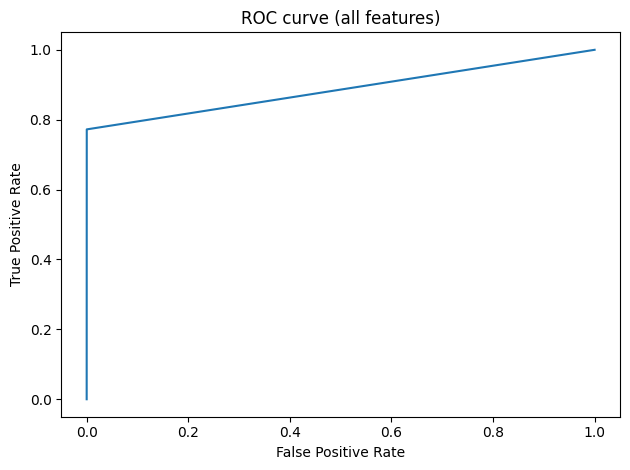

In [12]:
metrics = me.compute_metrics(
    y_true=y_test,
    y_pred=y_fraud_pred,
    metrics_df=None,
    dataset_label='v7 training'
)

print("Precision:", metrics["precision"][0])
print("Recall:", metrics["recall"][0])
print("F1 Score:", metrics["f1-score"][0])
print("Accuracy:", metrics["accuracy"][0])

fpr, tpr, auc = me.compute_roc_auc(y_test, y_fraud_pred)
print("AUC Score:", auc)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (all features)")
plt.tight_layout()
plt.show()

#### ***Training and Evaluation (for all feature vectors)***

In [84]:
# Split data
X_train, y_train, _, _, X_test, y_test = data_split(dataset.to_numpy(), train_size=0.8)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 30), (227845, 1), (56962, 30), (56962, 1))

In [85]:
# Number of samples to generate
n_samples = 3000

# Minority: fraudulent samples
X_minority = X_train[y_train[:, 0] == 1]

# Apply SMOTE (only on the training set)
X_smote = fit_resample(X_minority, n_samples, k=15)
y_smote = jnp.ones((n_samples, 1))

# Add synthetic data to the training set
X_train = jnp.concatenate((X_train, X_smote), axis=0)
y_train = jnp.concatenate((y_train, y_smote), axis=0)

In [86]:
# Normalize training set
X_train_normalized, data_train_min, data_train_max = min_max(X_train)

# Normalize testing set
X_test_normalized, _, _ = min_max(X_test, data_train_min, data_train_max)

In [87]:
# Metrics
metrics_training = pd.DataFrame()
metrics_testing = pd.DataFrame()

# ROC AUC scores
roc_auc_training = {}
roc_auc_testing = {}

# Run the model for each feature vector
for key, value in me.feature_vectors.items():
    print(f"Running model for feature vector {key}...")

    # Get dataset for the current feature vector
    X_train_curr = X_train_normalized[:, np.array(me.feature_masks[key]).astype(bool)]
    X_test_curr = X_test_normalized[:, np.array(me.feature_masks[key]).astype(bool)]

    # Initialize weights and biases
    params = ann.initialize_parameters([X_train_curr.shape[1], 30, 20, 1])
    
    # Train ANN
    updated_params, history = ann.fit(
        X=X_train_curr, 
        y=y_train, 
        params=params,    
        optimizer=ann.RMSprop(
            loss_function=ann.regularized_loss(
                ann.cross_entropy(),
                penalization=0.5
            ),
            epochs=2000,
            batch_size=256,
            learning_rate=0.001,
            decay_rate=0.9,
            epsilon=1e-8,
        )
    )
    
    # Get training predicted labels
    y_train_pred = ann.predict(X_train_curr, updated_params)
    train_fraud_pred = y_train_pred >= 0.5

    # Save training metrics
    metrics_training = me.compute_metrics(
        y_true=y_train, 
        y_pred=train_fraud_pred, 
        metrics_df=metrics_training,
        dataset_label=key + ' training'
    )
    roc_auc_training[key] = me.compute_roc_auc(y_train, y_train_pred)
    
    # Get validation predicted labels
    # ...
    
    # Get testing predicted labels
    y_test_pred = ann.predict(X_test_curr, updated_params)
    test_fraud_pred = y_test_pred >= 0.5

    # Save testing metrics
    metrics_testing = me.compute_metrics(
        y_true=y_test, 
        y_pred=test_fraud_pred, 
        metrics_df=metrics_testing,
        dataset_label=key + ' testing'
    )
    roc_auc_testing[key] = me.compute_roc_auc(y_test, y_test_pred)

Running model for feature vector v1...
Running model for feature vector v2...
Running model for feature vector v3...
Running model for feature vector v4...
Running model for feature vector v5...
Running model for feature vector v6...
Running model for feature vector v7...


In [88]:
metrics_training    

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1 training,2457,227398,56,934,0.995711,0.724565,0.977716,0.832317,230845,[3391.0]
1,v2 training,2430,227381,73,961,0.995521,0.716603,0.970835,0.824567,230845,[3391.0]
2,v3 training,2673,227365,89,718,0.996504,0.788263,0.967777,0.868844,230845,[3391.0]
3,v4 training,2735,227386,68,656,0.996864,0.806547,0.975740,0.883113,230845,[3391.0]
4,v5 training,2786,227353,101,605,0.996942,0.821587,0.965016,0.887544,230845,[3391.0]
5,v6 training,2978,227370,84,413,0.997847,0.878207,0.972567,0.922982,230845,[3391.0]
6,v7 training,2859,227352,102,532,0.997254,0.843114,0.965552,0.900189,230845,[3391.0]


In [89]:
metrics_testing

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1 testing,68,56848,13,33,0.999192,0.673267,0.839506,0.747253,56962,[101.0]
1,v2 testing,67,56844,17,34,0.999105,0.663366,0.797619,0.724324,56962,[101.0]
2,v3 testing,77,56842,19,24,0.999245,0.762376,0.802083,0.781726,56962,[101.0]
3,v4 testing,76,56843,18,25,0.999245,0.752475,0.808511,0.779487,56962,[101.0]
4,v5 testing,84,56834,27,17,0.999228,0.831683,0.756757,0.792453,56962,[101.0]
5,v6 testing,82,56840,21,19,0.999298,0.811881,0.796117,0.803922,56962,[101.0]
6,v7 testing,83,56841,20,18,0.999333,0.821782,0.805825,0.813725,56962,[101.0]


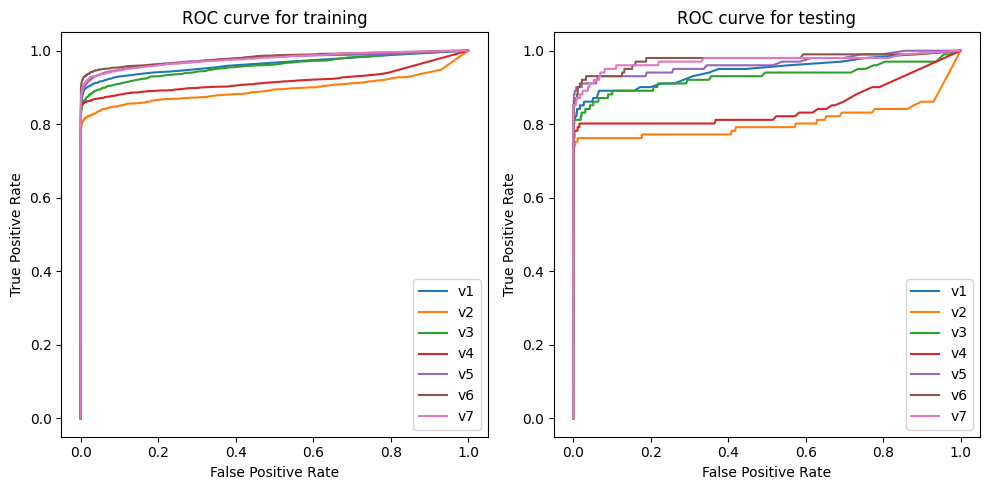

Training AUC:
v1 -> 0.96
v2 -> 0.89
v3 -> 0.96
v4 -> 0.92
v5 -> 0.98
v6 -> 0.98
v7 -> 0.98

Testing AUC:
v1 -> 0.95
v2 -> 0.81
v3 -> 0.93
v4 -> 0.85
v5 -> 0.96
v6 -> 0.98
v7 -> 0.97


In [91]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

#ROC curve for training
for i in roc_auc_training.keys():
    axs[0].plot(roc_auc_training[i][0], roc_auc_training[i][1], label = i)
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve for training")
    axs[0].legend()

#ROC curve for testing
for i in roc_auc_testing.keys():
    axs[1].plot(roc_auc_testing[i][0], roc_auc_testing[i][1], label = i)
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC curve for testing")
    axs[1].legend()

plt.tight_layout()
plt.show()

print("Training AUC:")
for i, auc in roc_auc_training.items():
    print(f"{i} -> {auc[2]:.2f}")

print("\nTesting AUC:")
for i, auc in roc_auc_testing.items():
    print(f"{i} -> {auc[2]:.2f}")